In [1]:
import os
cwd = os.getcwd()

# protection against running this cell multiple times
assert os.path.dirname(cwd).split('/')[-1] == 'master-thesis','Oops, directory already changed previously as indended. Ignoring...'

# change working directory (if assert passed)
new_cwd = os.path.dirname(cwd) # parent directory
os.chdir(new_cwd)

# Imports

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import os
import json

from rnn_utils import DiagnosesDataset, split_dataset, MYCOLLATE
from rnn_utils import train_one_epoch, eval_model
from Logits2Predictions import Logits2Predictions

from mourga_variational.variational_rnn import VariationalRNN
from utils import plot_reliability,get_prediction_thresholds

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence, pack_sequence

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

idx = pd.IndexSlice

from config import Settings; settings = Settings()

# Parameters

In [3]:
reliability_15_file = os.path.join('data/deterministic/A','reliability.csv')
reliability_1_file = os.path.join('data/deterministic/B','reliability.csv')
reliability_0_file = os.path.join('data/deterministic/C','reliability.csv')

## Read reliability

# Comparing ECE between two models

In [4]:
reliability_15 = pd.read_csv(reliability_15_file,index_col=[0,1]).sort_index()
reliability_1 = pd.read_csv(reliability_1_file,index_col=[0,1]).sort_index()
reliability_0 = pd.read_csv(reliability_0_file,index_col=[0,1]).sort_index()

reliability_15.head(3)

ece  accuracies  rel_freq_positive_examples  \
diag   bin                                                     
diag_0 0    0.001909    0.013793                    0.003606   
       1    0.001909    1.000000                    1.000000   
       2    0.001909    0.000000                    0.000000   

            n_samples_predicted_class  perc_samples_predicted_class  \
diag   bin                                                            
diag_0 0                          145                      0.074627   
       1                            1                      0.000515   
       2                            1                      0.000515   

            n_samples_positive_class  perc_samples_positive_class  nbins  
diag   bin                                                                
diag_0 0                        1941                     0.998971     10  
       1                           1                     0.000515     10  
       2                           1                     0.000515     10

In [5]:
desc_15 = reliability_15.groupby(['diag']).ece.mean().describe()
desc_1 = reliability_1.groupby(['diag']).ece.mean().describe()
desc_0 = reliability_0.groupby(['diag']).ece.mean().describe()

desc_15.name = 'ece 15'
desc_1.name = 'ece 1'
desc_1.name = 'ece 0'
pd.concat([desc_15,desc_1,desc_0],axis=1)

,ece 15,ece 0,ece
count,272.000000,272.000000,272.000000
mean,0.010329,0.011146,0.380889
std,0.013408,0.016339,0.136114
min,0.000041,0.000186,0.026561
25%,0.001753,0.001643,0.301468
50%,0.004630,0.004650,0.440011
75%,0.012496,0.012466,0.480757
max,0.064692,0.105484,0.527907


<AxesSubplot:ylabel='Frequency'>

<AxesSubplot:ylabel='Frequency'>

<AxesSubplot:ylabel='Frequency'>

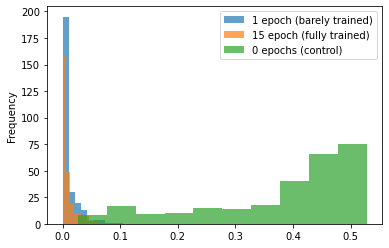

In [46]:
reliability_1.groupby(['diag']).ece.mean().plot.hist(alpha=0.7,label='1 epoch (barely trained)')
reliability_15.groupby(['diag']).ece.mean().plot.hist(alpha=0.7,label='15 epoch (fully trained)')
reliability_0.groupby(['diag']).ece.mean().plot.hist(alpha=0.7,label='0 epochs (control)')
plt.legend()

<AxesSubplot:>

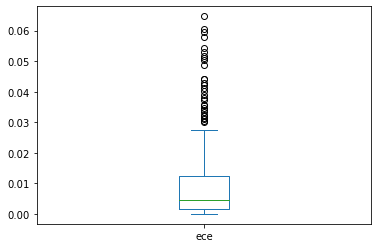

In [29]:
reliability_15.groupby(['diag']).ece.mean().plot.box()